Let's import the required libraries first.

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
import warnings

In [100]:
# Set random seed for reproducibility
np.random.seed(42)

# Suppress warnings
warnings.filterwarnings("ignore")

In [101]:
!mkdir data/
!wget https://raw.githubusercontent.com/Shivaraj-R-Kolli/batteries/main/lithium-ion_batteries%5B1%5D.csv



mkdir: cannot create directory ‘data/’: File exists
--2024-04-26 08:38:06--  https://raw.githubusercontent.com/Shivaraj-R-Kolli/batteries/main/lithium-ion_batteries%5B1%5D.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26952 (26K) [text/plain]
Saving to: ‘lithium-ion_batteries[1].csv’

lithium-ion_batteri 100%[===================>]  26.32K  --.-KB/s    in 0.002s  

2024-04-26 08:38:06 (16.7 MB/s) - ‘lithium-ion_batteries[1].csv’ saved [26952/26952]



In [102]:
df = pd.read_csv('/content/lithium-ion_batteries[1].csv')

df.head()

Materials Id       Formula Spacegroup  Formation Energy (eV)  \
0    mp-849394     Li2MnSiO4         Pc                 -2.699   
1    mp-783909     Li2MnSiO4      P21/c                 -2.696   
2    mp-761311    Li4MnSi2O7         Cc                 -2.775   
3    mp-761598  Li4Mn2Si3O10       C2/c                 -2.783   
4    mp-767709  Li2Mn3Si3O10       C2/c                 -2.747   

   E Above Hull (eV)  Band Gap (eV)  Nsites  Density (gm/cc)   Volume  \
0              0.006          3.462      16            2.993  178.513   
1              0.008          2.879      32            2.926  365.272   
2              0.012          3.653      28            2.761  301.775   
3              0.013          3.015      38            2.908  436.183   
4              0.016          2.578      36            3.334  421.286   

   Has Bandstructure Crystal System  
0               True     monoclinic  
1               True     monoclinic  
2               True     monoclinic  
3               True     monoclinic  
4               True     monoclinic

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Materials Id           339 non-null    object 
 1   Formula                339 non-null    object 
 2   Spacegroup             339 non-null    object 
 3   Formation Energy (eV)  339 non-null    float64
 4   E Above Hull (eV)      339 non-null    float64
 5   Band Gap (eV)          339 non-null    float64
 6   Nsites                 339 non-null    int64  
 7   Density (gm/cc)        339 non-null    float64
 8   Volume                 339 non-null    float64
 9   Has Bandstructure      339 non-null    bool   
 10  Crystal System         339 non-null    object 
dtypes: bool(1), float64(5), int64(1), object(4)
memory usage: 26.9+ KB


To prepare the dataset, missing data is visually checked by using a heatmap available through the Seaborn library.

<Axes: >

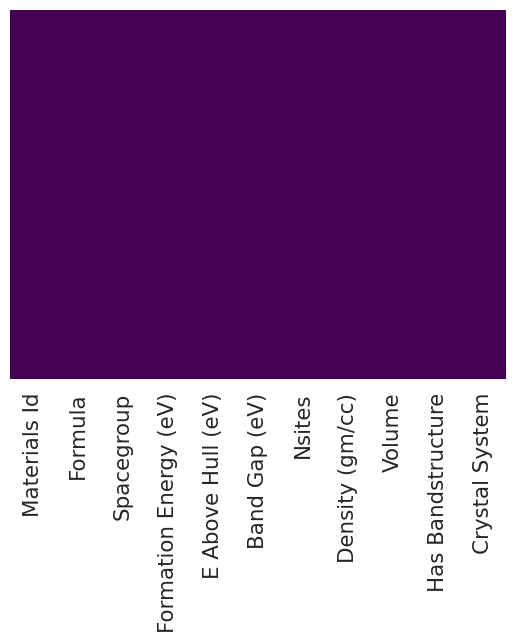

In [104]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Generate and check the pairplot of the dataframe.

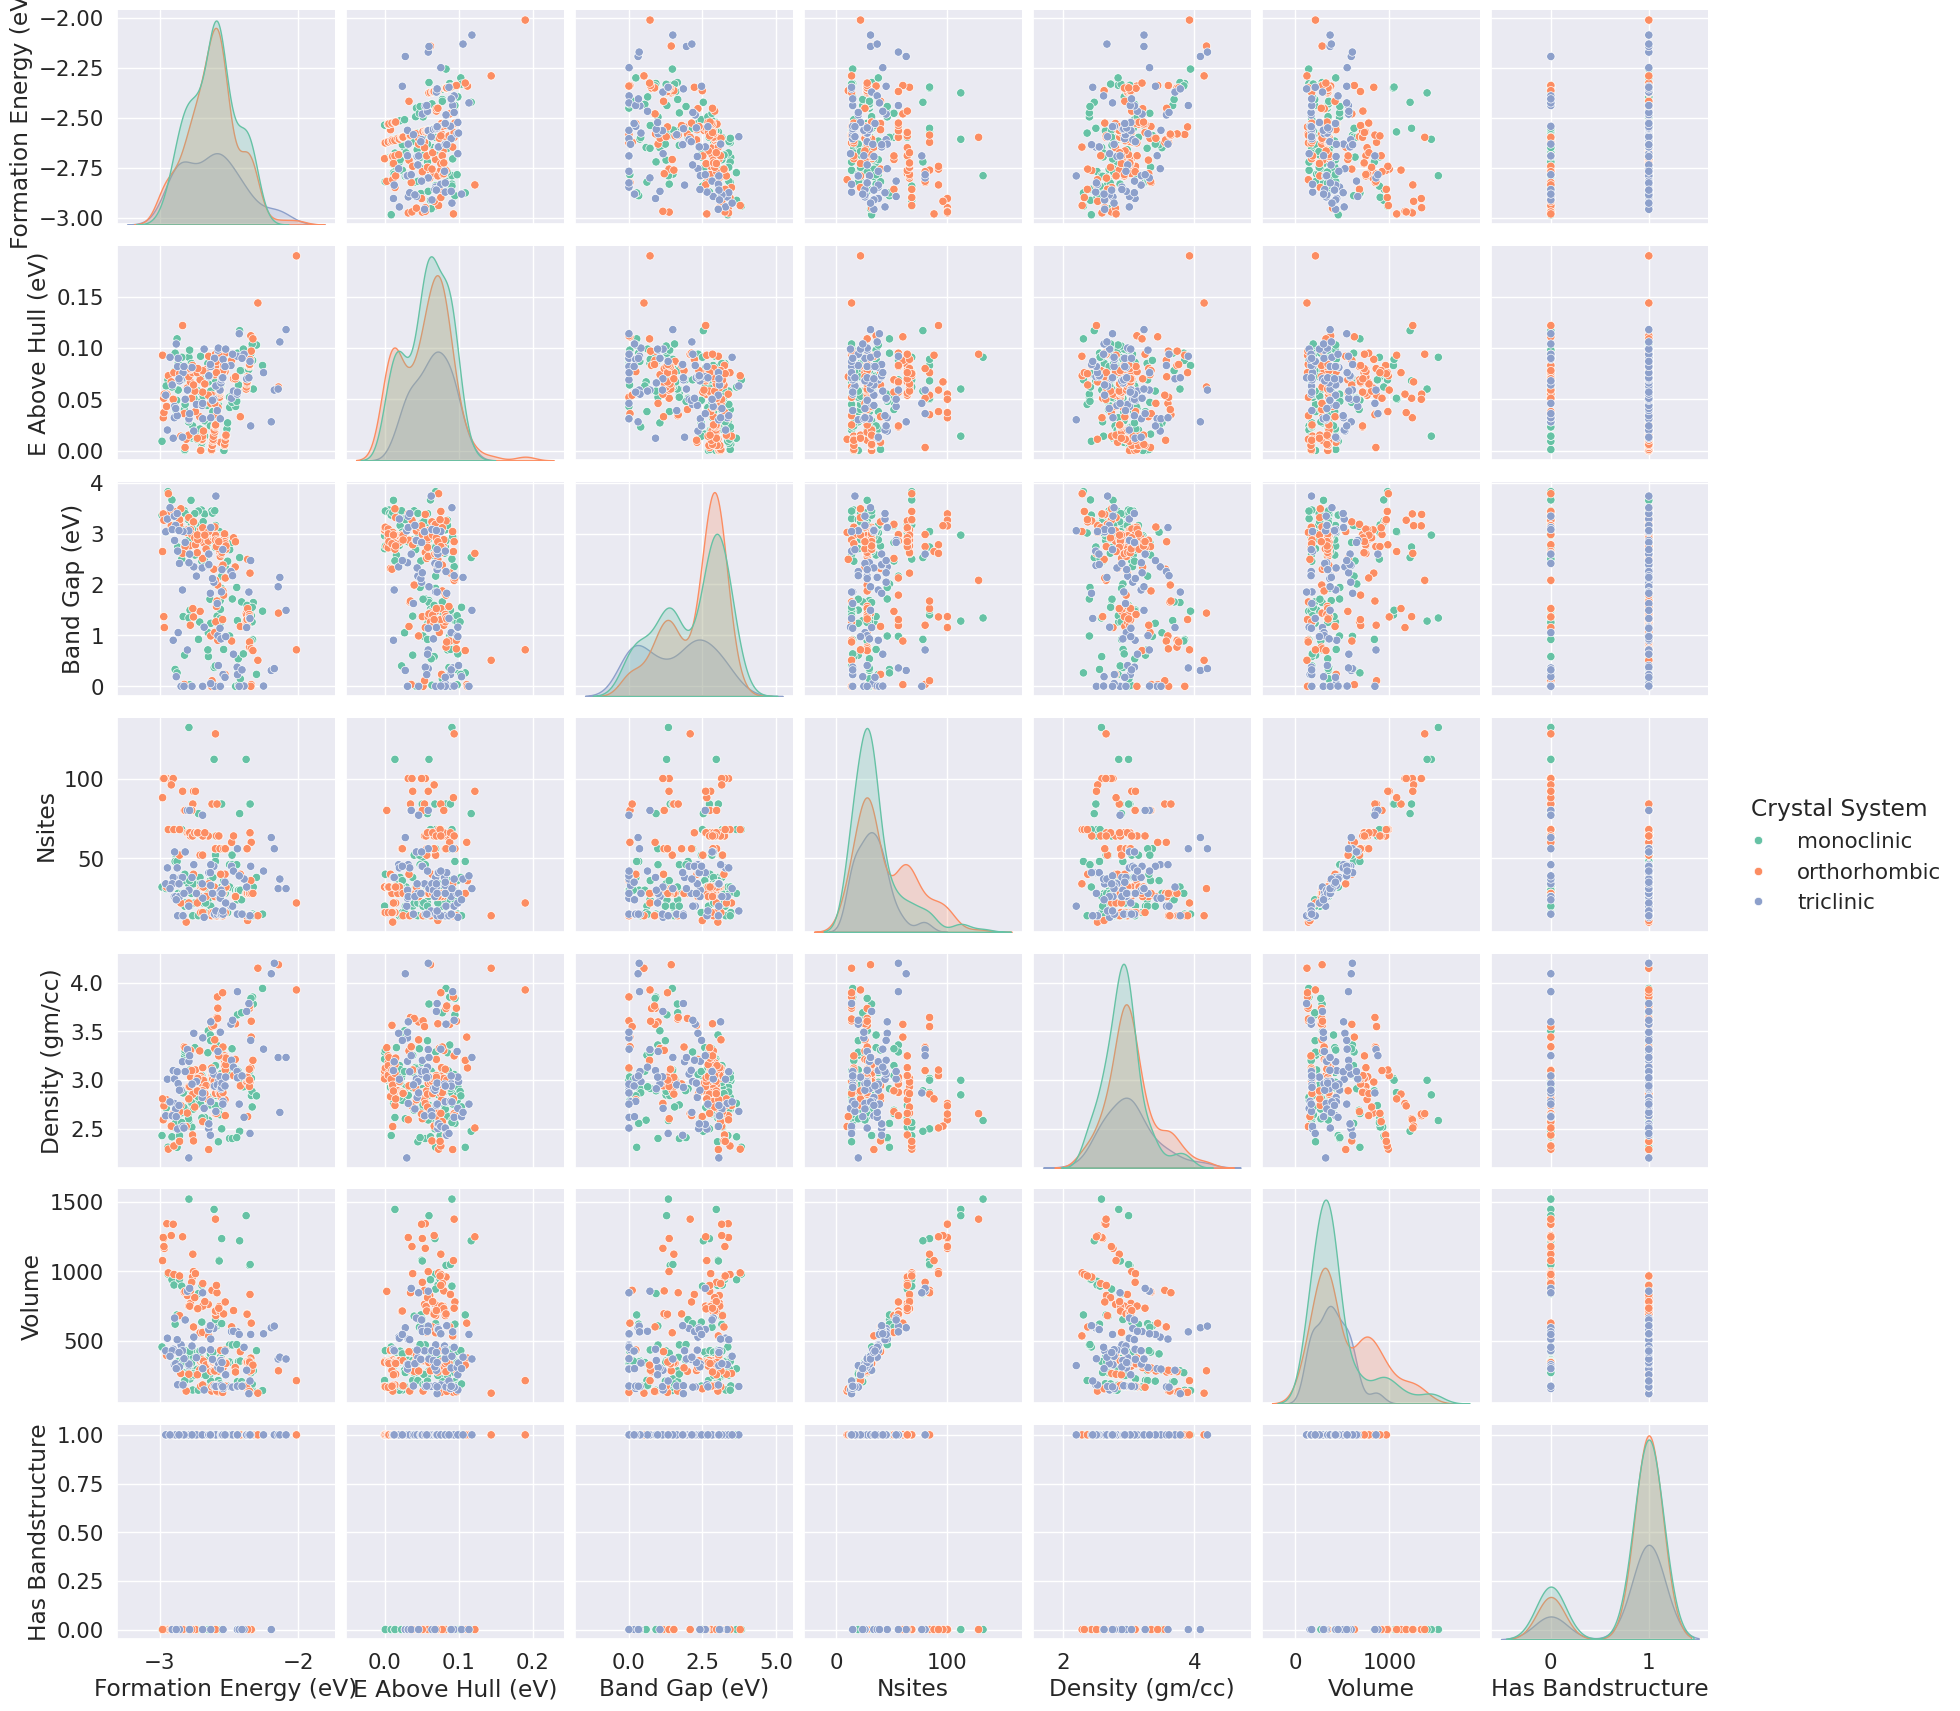

In [105]:
sns.pairplot(df,hue='Crystal System',palette='Set2')

Columns with variables not needed in building models such as materials id, formula, and space group are removed to clean the dataset.

In [106]:
df.drop(['Materials Id','Formula','Spacegroup'],
        axis=1,inplace=True)
df.head()

Formation Energy (eV)  E Above Hull (eV)  Band Gap (eV)  Nsites  \
0                 -2.699              0.006          3.462      16   
1                 -2.696              0.008          2.879      32   
2                 -2.775              0.012          3.653      28   
3                 -2.783              0.013          3.015      38   
4                 -2.747              0.016          2.578      36   

   Density (gm/cc)   Volume  Has Bandstructure Crystal System  
0            2.993  178.513               True     monoclinic  
1            2.926  365.272               True     monoclinic  
2            2.761  301.775               True     monoclinic  
3            2.908  436.183               True     monoclinic  
4            3.334  421.286               True     monoclinic

In [107]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Formation Energy (eV)  339 non-null    float64
 1   E Above Hull (eV)      339 non-null    float64
 2   Band Gap (eV)          339 non-null    float64
 3   Nsites                 339 non-null    int64  
 4   Density (gm/cc)        339 non-null    float64
 5   Volume                 339 non-null    float64
 6   Has Bandstructure      339 non-null    bool   
 7   Crystal System         339 non-null    object 
dtypes: bool(1), float64(5), int64(1), object(1)
memory usage: 19.0+ KB


Generate a frequency distribution of the Crystal Systems and whether or not it has a bandstructure.

<Axes: xlabel='Crystal System', ylabel='count'>

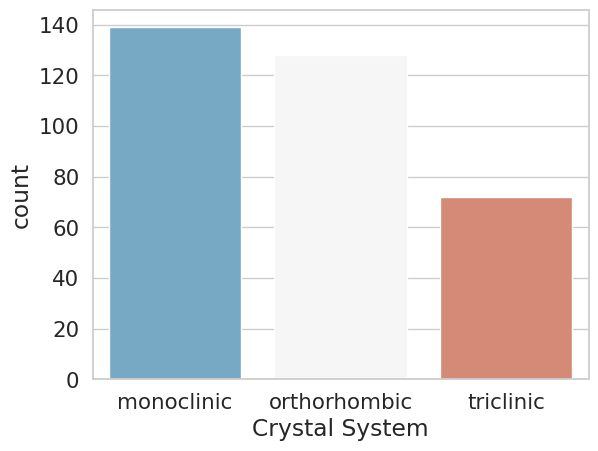

In [108]:
sns.set_style('whitegrid')
sns.countplot(x='Crystal System',
              data=df,palette='RdBu_r')


<Axes: xlabel='Crystal System', ylabel='count'>

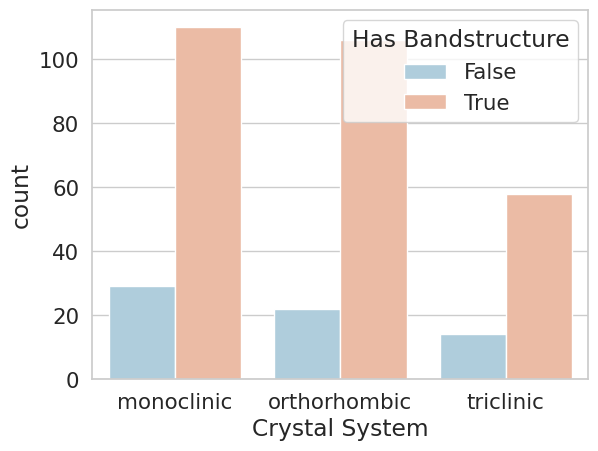

In [109]:
sns.set_style('whitegrid')
sns.countplot(x='Crystal System',hue='Has Bandstructure',data=df,palette='RdBu_r')

**Logistic Regression**

Build a Logistic Regression model. Split the data into a training set and a test set.

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(df.drop('Crystal System',axis=1),
                                                    df['Crystal System'], test_size=0.30,
                                                    random_state=101)

The test size is set to 30 leaving the training set to be at 70. Random state is set to 101.

Train the model.

In [111]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression()

Predict the values for the testing data and print a classification report to obtain the precision, recall and f1-score.

In [112]:
lr_predictions = logmodel.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test,lr_predictions))

              precision    recall  f1-score   support

  monoclinic       0.46      0.76      0.57        41
orthorhombic       0.68      0.41      0.52        41
   triclinic       0.40      0.20      0.27        20

    accuracy                           0.51       102
   macro avg       0.51      0.46      0.45       102
weighted avg       0.54      0.51      0.49       102



Print the accuracy score.

In [113]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
print(accuracy_score(y_test, lr_predictions))

0.5098039215686274


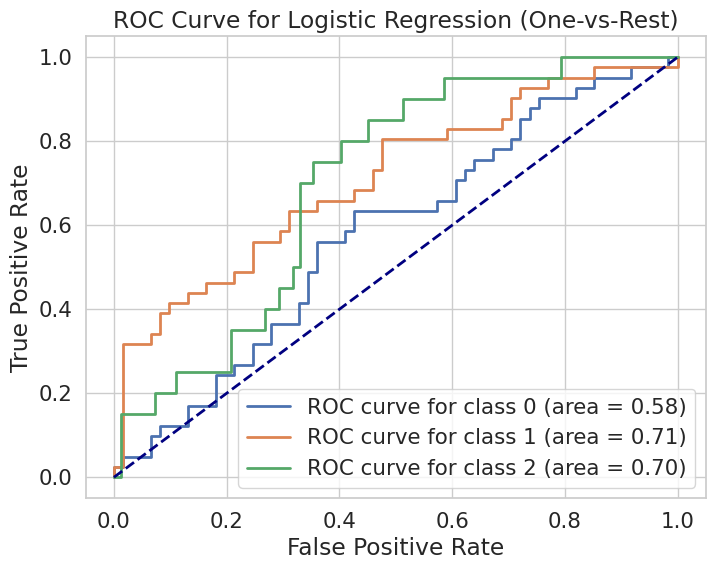

In [114]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize the target variable
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Calculate the probabilities of the classes
lr_probs = logmodel.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], lr_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y_test))):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for class {0} (area = {1:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()


Show the confusion matrix of the prediction.

<Axes: xlabel='Predicted', ylabel='Actual'>

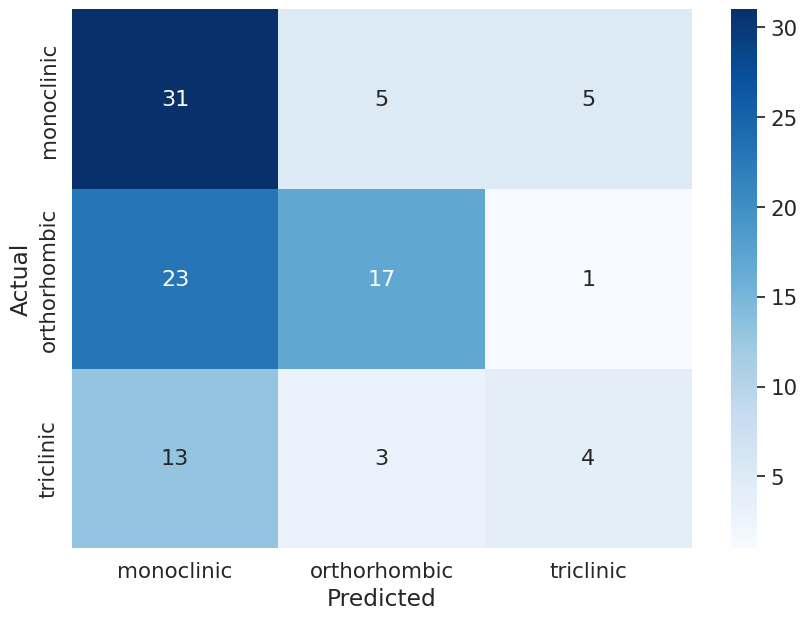

In [115]:
data = confusion_matrix(y_test, lr_predictions)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(lr_predictions))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

# Decision Tree



Build the Decision Tree model and split the data into a training set and test set.

In [116]:
from sklearn.model_selection import train_test_split

X = df.drop('Crystal System',axis=1)
y = df['Crystal System']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

The test size is set to 30 leaving the train set at 70.

Train the model.

In [117]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

dtree.tree_.node_count, dtree.tree_.max_depth

(139, 15)

Predict the values for the testing data and generate the classification report to check the precision, recall and f1-score.

In [118]:
dt_predictions = dtree.predict(X_test)

In [119]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

print(classification_report(y_test,dt_predictions))

              precision    recall  f1-score   support

  monoclinic       0.51      0.55      0.53        44
orthorhombic       0.55      0.55      0.55        33
   triclinic       0.36      0.32      0.34        25

    accuracy                           0.49       102
   macro avg       0.47      0.47      0.47       102
weighted avg       0.49      0.49      0.49       102



In [120]:

print(accuracy_score(y_test,dt_predictions))


0.49019607843137253


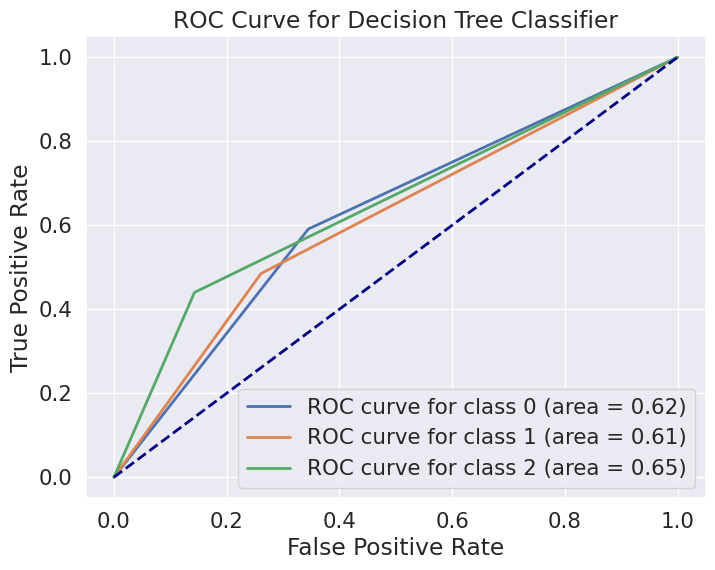

In [121]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier

# Fit the Decision Tree classifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

# Predict probabilities for each class
dt_probs = dtree.predict_proba(X_test)

# Binarize the target variable
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], dt_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y_test))):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for class {0} (area = {1:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree Classifier')
plt.legend(loc='lower right')
plt.show()


 confusion matrix and the accuracy score of the prediction.

In [122]:
print(confusion_matrix(y_test,dt_predictions))

[[24  9 11]
 [12 18  3]
 [11  6  8]]


In [123]:
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydot

features = list(df.columns[1:])
features

['E Above Hull (eV)',
 'Band Gap (eV)',
 'Nsites',
 'Density (gm/cc)',
 'Volume',
 'Has Bandstructure',
 'Crystal System']

In [124]:
!pip install Graphviz

In [125]:
!pip install pydotplus

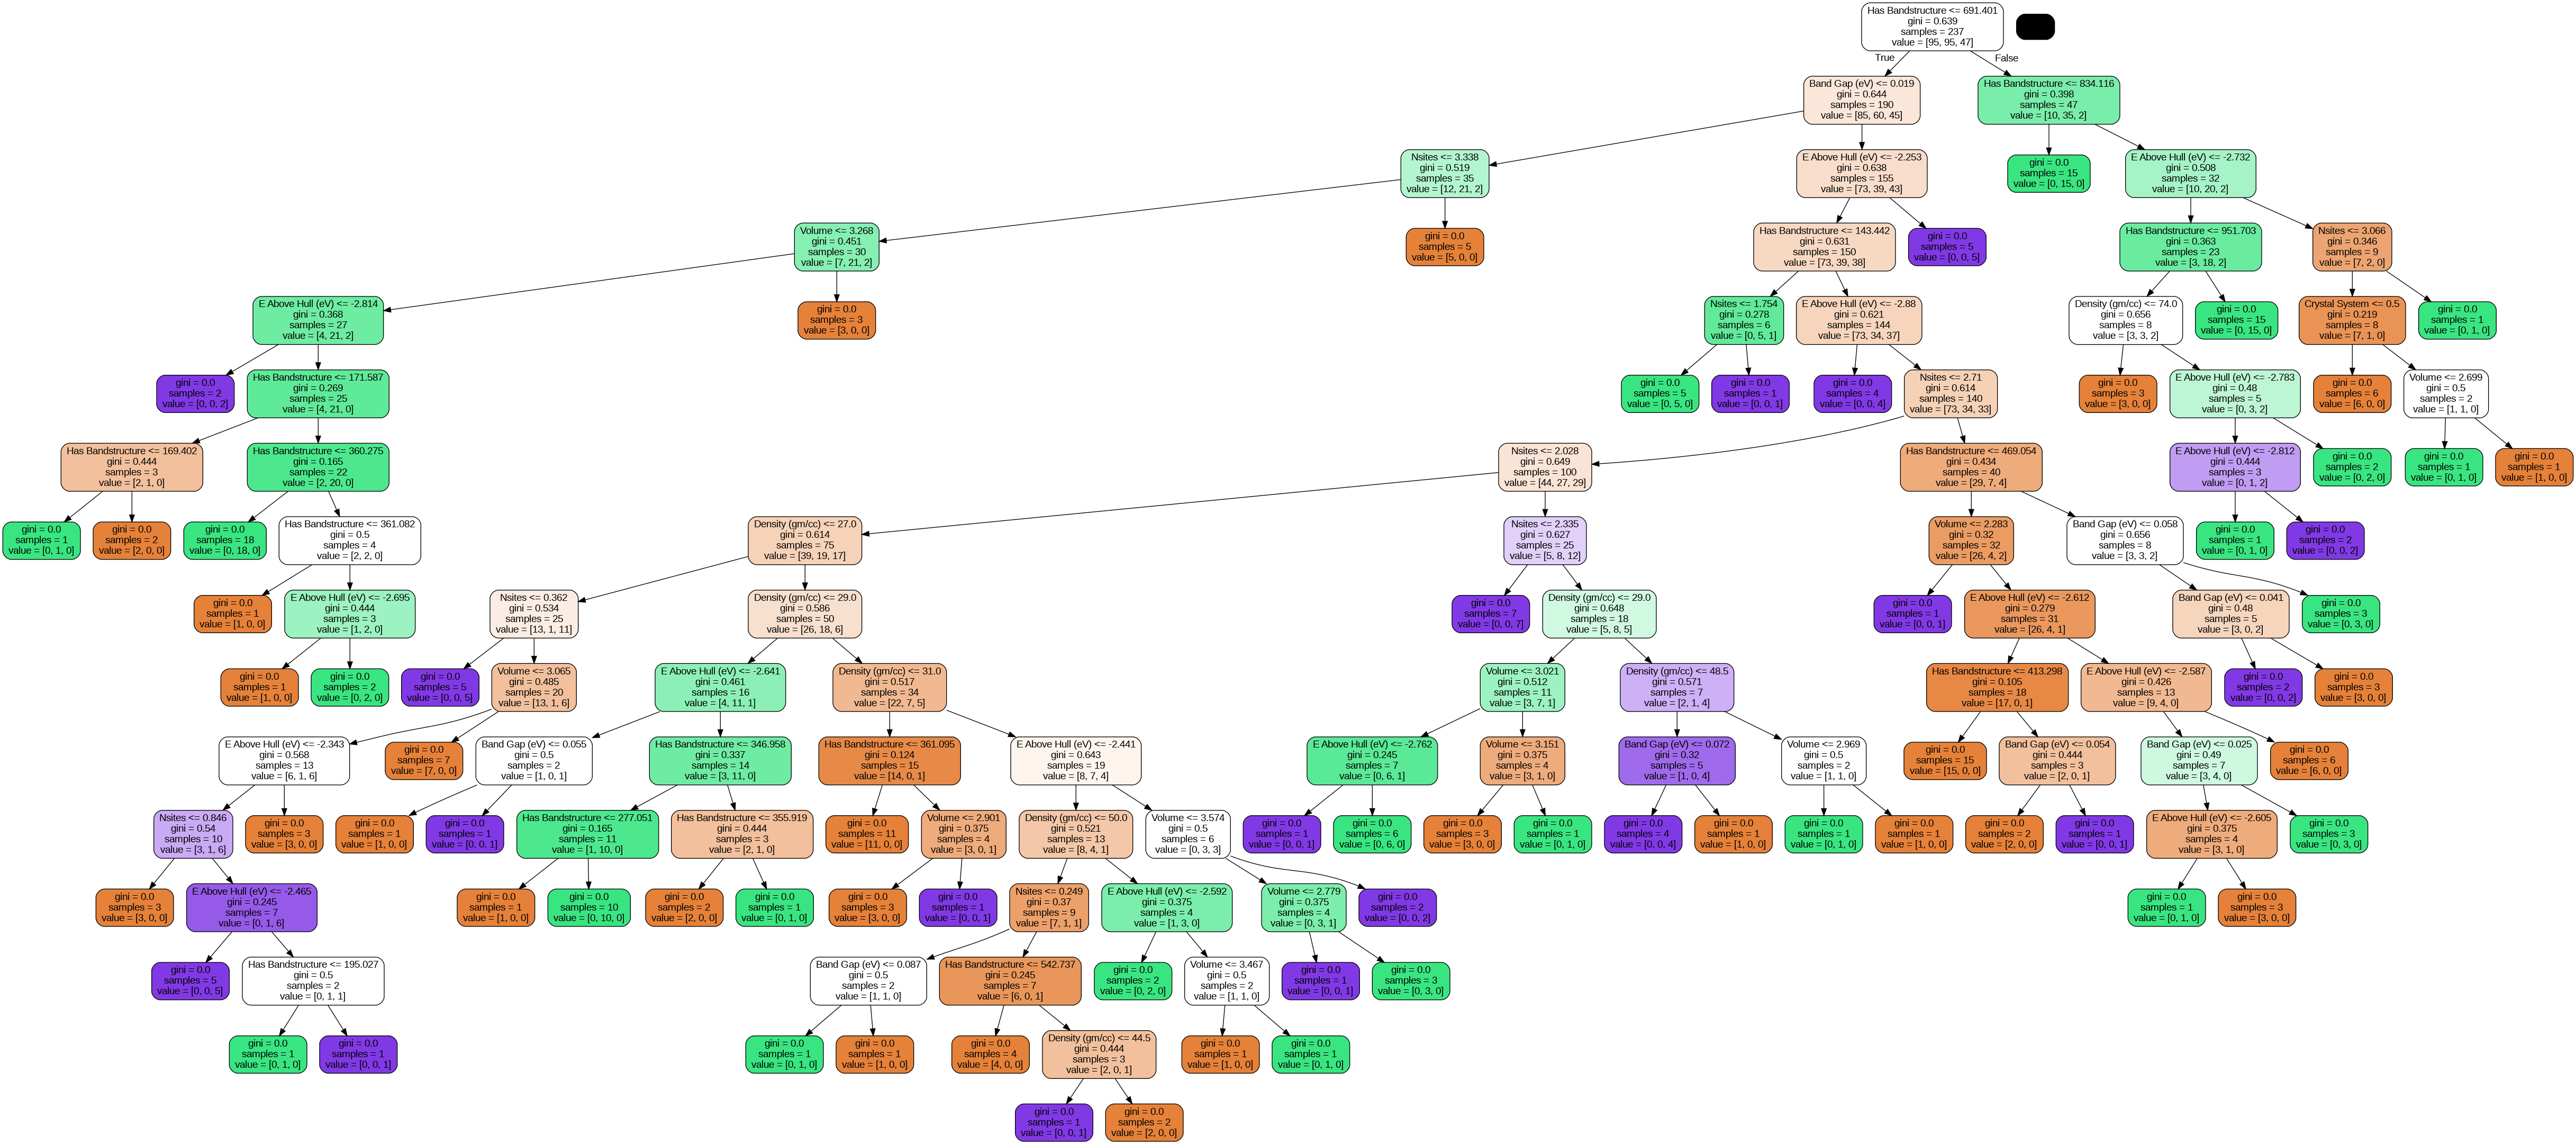

In [126]:
from io import StringIO
from IPython.display import Image, display
import pydotplus

from sklearn.tree import export_graphviz
dot_data = StringIO()

export_graphviz(dtree, out_file=dot_data, feature_names=features,filled=True,rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

    # View the tree image
filename = 'Batteries.png'
graph.write_png(filename)
img = Image(filename=filename)
display(img)

# Random Forest



Build the Random Forest model and split the data into a training set and test set.

In [127]:
from sklearn.model_selection import train_test_split

X = df.drop('Crystal System',axis=1)
y = df['Crystal System']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

Train the random forest model and predict the class of the Crystal Systems.

In [128]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train,y_train)
rf_predictions = rfc.predict(X_test)

The test size is set to 30 leaving the train set at 70. The Random Forest Classifier is imported from sklearn and the estimators are set to 200.


Generate a classification report to obtain the precision, recall and f1-score of the model.

In [129]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_auc_score
print(classification_report(y_test,rf_predictions))

              precision    recall  f1-score   support

  monoclinic       0.54      0.71      0.61        41
orthorhombic       0.67      0.63      0.65        38
   triclinic       0.83      0.43      0.57        23

    accuracy                           0.62       102
   macro avg       0.68      0.59      0.61       102
weighted avg       0.65      0.62      0.62       102



In [130]:


# Print the accuracy score.
print(accuracy_score(y_test, rf_predictions))


0.6176470588235294


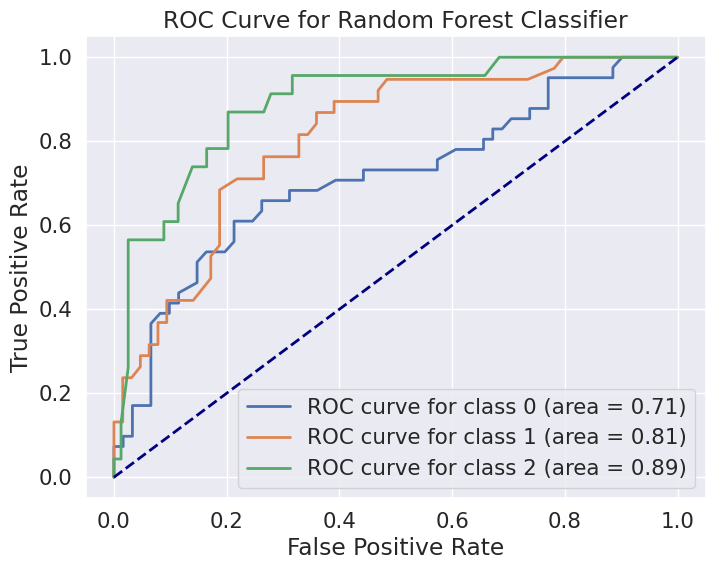

In [131]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier

# Fit the Random Forest classifier
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)

# Predict probabilities for each class
rf_probs = rfc.predict_proba(X_test)

# Binarize the target variable
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], rf_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y_test))):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for class {0} (area = {1:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()


 confusion matrix and the accuracy score of the model.

<Axes: >

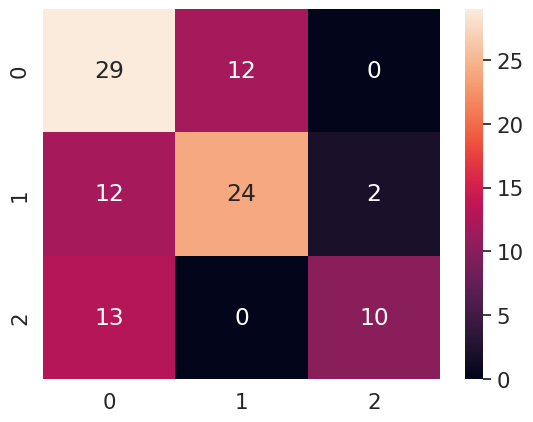

In [132]:


cm = confusion_matrix(y_test,rf_predictions)
sns.heatmap(cm,annot=True,fmt='g')


# K Nearest Neighbors (KNN)



Build the K Nearest Neighbors model and split the data into a training set and test set.

In [133]:
from sklearn.preprocessing import StandardScaler

In [134]:
scaler = StandardScaler()

In [135]:
scaler.fit(df.drop('Crystal System',axis=1))

StandardScaler()

In [136]:
scaled_features = scaler.transform(df.drop('Crystal System',axis=1))

In [137]:
df_feat = pd.DataFrame(scaled_features,columns=df.columns[:-1])
df_feat.head()

Formation Energy (eV)  E Above Hull (eV)  Band Gap (eV)    Nsites  \
0              -0.447048          -1.722253       1.272374 -0.988690   
1              -0.430703          -1.656286       0.735721 -0.296020   
2              -0.861132          -1.524351       1.448190 -0.469187   
3              -0.904720          -1.491367       0.860909 -0.036268   
4              -0.708575          -1.392416       0.458650 -0.122852   

   Density (gm/cc)    Volume  Has Bandstructure  
0         0.025455 -0.989769           0.487059  
1        -0.164107 -0.350714           0.487059  
2        -0.630939 -0.567989           0.487059  
3        -0.215034 -0.108070           0.487059  
4         0.990242 -0.159045           0.487059

In [138]:
from sklearn.model_selection import train_test_split

In [139]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features,df['Crystal System'],
                                                    test_size=0.30)

In [140]:
from sklearn.neighbors import KNeighborsClassifier

In [141]:
knn = KNeighborsClassifier(n_neighbors=1)

In [142]:
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [143]:
pred = knn.predict(X_test)

Evaluate the KNN model.

In [144]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [145]:


print(accuracy_score(y_test, pred))


0.5686274509803921


In [146]:
print(confusion_matrix(y_test,pred))

[[24 16  6]
 [11 24  4]
 [ 5  2 10]]


In [147]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

  monoclinic       0.60      0.52      0.56        46
orthorhombic       0.57      0.62      0.59        39
   triclinic       0.50      0.59      0.54        17

    accuracy                           0.57       102
   macro avg       0.56      0.58      0.56       102
weighted avg       0.57      0.57      0.57       102



Choose a K value. Create a method to pick a good value of K.

In [148]:
error_rate = []


for i in range(1,40):

    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Create a visualization to compare the error rate and k value.

Text(0, 0.5, 'Error Rate')

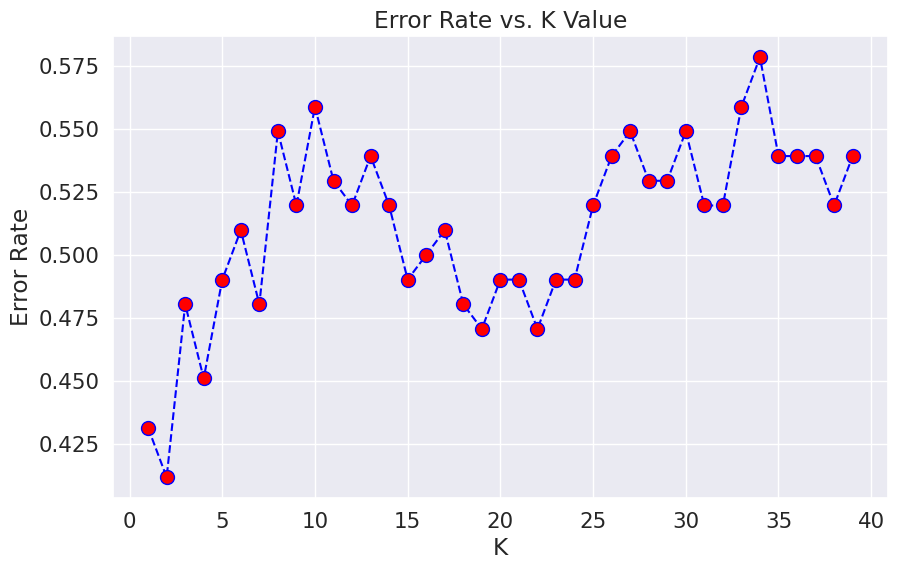

In [149]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [150]:
# K = 1
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print('WITH K=1')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=1


[[24 16  6]
 [11 24  4]
 [ 5  2 10]]


              precision    recall  f1-score   support

  monoclinic       0.60      0.52      0.56        46
orthorhombic       0.57      0.62      0.59        39
   triclinic       0.50      0.59      0.54        17

    accuracy                           0.57       102
   macro avg       0.56      0.58      0.56       102
weighted avg       0.57      0.57      0.57       102



In [151]:
#K = 23
knn = KNeighborsClassifier(n_neighbors=23)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print('WITH K=23')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=23


[[22 19  5]
 [10 28  1]
 [11  4  2]]


              precision    recall  f1-score   support

  monoclinic       0.51      0.48      0.49        46
orthorhombic       0.55      0.72      0.62        39
   triclinic       0.25      0.12      0.16        17

    accuracy                           0.51       102
   macro avg       0.44      0.44      0.43       102
weighted avg       0.48      0.51      0.49       102



Fit the K-nearest neighbors model again with n_neighbors=3 but this time use distance for the weights. Calculate the accuracy using the function you created above.

In [152]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')

knn = knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.5196078431372549


Fit another K-nearest neighbors model. This time use uniform weights but set the power parameter for the Minkowski distance metric to be 1 (p=1) i.e. Manhattan Distance.

In [153]:
knn = KNeighborsClassifier(n_neighbors=5, p=1)

knn = knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.5098039215686274


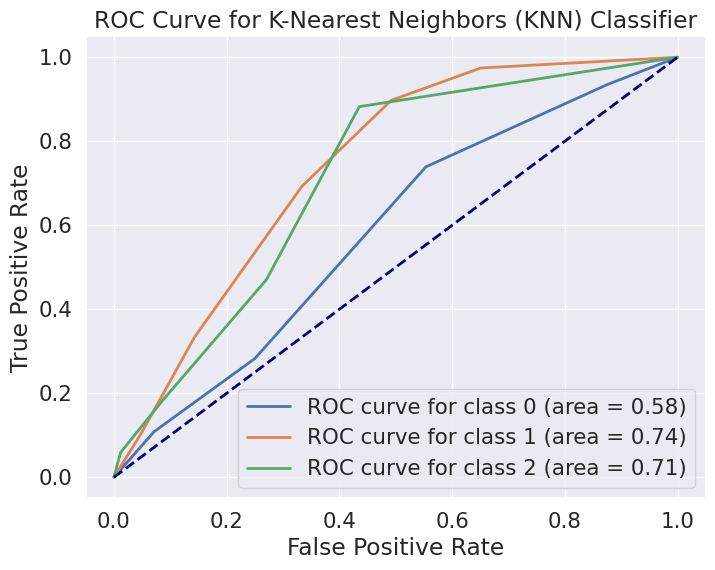

In [154]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Fit KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict probabilities for each class
knn_probs = knn.predict_proba(X_test)

# Binarize the target variable
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], knn_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y_test))):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for class {0} (area = {1:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for K-Nearest Neighbors (KNN) Classifier')
plt.legend(loc='lower right')
plt.show()


Fit a K-nearest neighbors model using values of k (n_neighbors) ranging from 1 to 20. Use uniform weights (the default).

In [155]:
# Fit the K-nearest neighbors model with different values of k
# Store the accuracy measurement for each k

score_list = list()

for k in range(1, 30):

    knn = KNeighborsClassifier(n_neighbors=k)
    knn = knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    score_list.append((k, score))

score_df = pd.DataFrame(score_list, columns=['k', 'accuracy'])

In [156]:


print(score_df['accuracy'].max())


0.5882352941176471


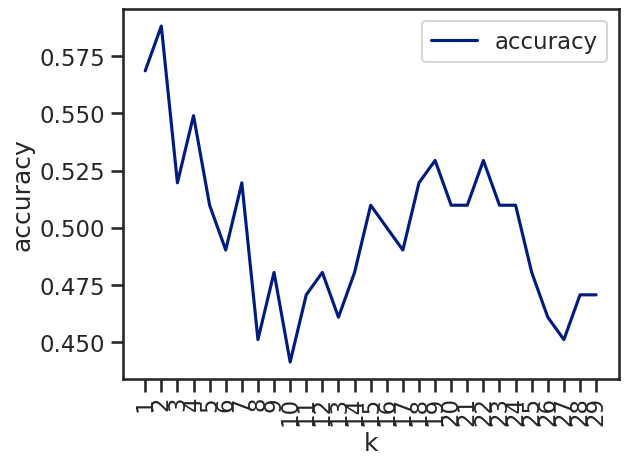

In [157]:

sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = score_df.set_index('k').plot()

ax.set(xlabel='k', ylabel='accuracy')
ax.set_xticks(range(1, 30))
plt.xticks(rotation=90)

plt.show()


# Support Vector Machines
Build the Support Vector Machines model and split the data into a training set and test set.

In [158]:
df

Formation Energy (eV)  E Above Hull (eV)  Band Gap (eV)  Nsites  \
0                   -2.699              0.006          3.462      16   
1                   -2.696              0.008          2.879      32   
2                   -2.775              0.012          3.653      28   
3                   -2.783              0.013          3.015      38   
4                   -2.747              0.016          2.578      36   
..                     ...                ...            ...     ...   
334                 -2.545              0.071          2.685      17   
335                 -2.250              0.076          0.005      42   
336                 -2.529              0.082          0.176      35   
337                 -2.348              0.087          1.333      14   
338                 -2.406              0.090          0.323      15   

     Density (gm/cc)   Volume  Has Bandstructure Crystal System  
0              2.993  178.513               True     monoclinic  
1              2.926  365.272               True     monoclinic  
2              2.761  301.775               True     monoclinic  
3              2.908  436.183               True     monoclinic  
4              3.334  421.286               True     monoclinic  
..               ...      ...                ...            ...  
334            2.753  171.772               True      triclinic  
335            3.318  552.402               True      triclinic  
336            2.940  428.648               True      triclinic  
337            2.451  214.044               True      triclinic  
338            3.043  176.207              False      triclinic  

[339 rows x 8 columns]

In [159]:
df.describe()

Formation Energy (eV)  E Above Hull (eV)  Band Gap (eV)      Nsites  \
count             339.000000         339.000000     339.000000  339.000000   
mean               -2.616950           0.058215       2.079740   38.837758   
std                 0.183809           0.030363       1.087968   23.133142   
min                -2.985000           0.000000       0.000000   10.000000   
25%                -2.757500           0.035500       1.265500   26.000000   
50%                -2.605000           0.062000       2.499000   31.000000   
75%                -2.525500           0.081500       2.968000   52.000000   
max                -2.012000           0.190000       3.823000  132.000000   

       Density (gm/cc)       Volume  
count       339.000000   339.000000  
mean          2.984003   467.765619  
std           0.353968   292.674559  
min           2.200000   122.581000  
25%           2.760500   286.381500  
50%           2.947000   358.537000  
75%           3.106000   601.696500  
max           4.201000  1518.850000

In [160]:
y = (df['Crystal System'] == 'monoclinic').astype(int)
fields = list(df.columns[:-1])
correlations = df[fields].corrwith(y)
correlations.sort_values(inplace=True)
correlations

Density (gm/cc)         -0.154916
Nsites                  -0.105014
Volume                  -0.082392
Has Bandstructure       -0.035773
E Above Hull (eV)       -0.013834
Formation Energy (eV)    0.006438
Band Gap (eV)            0.040440
dtype: float64

Create a pairplot for the dataset.

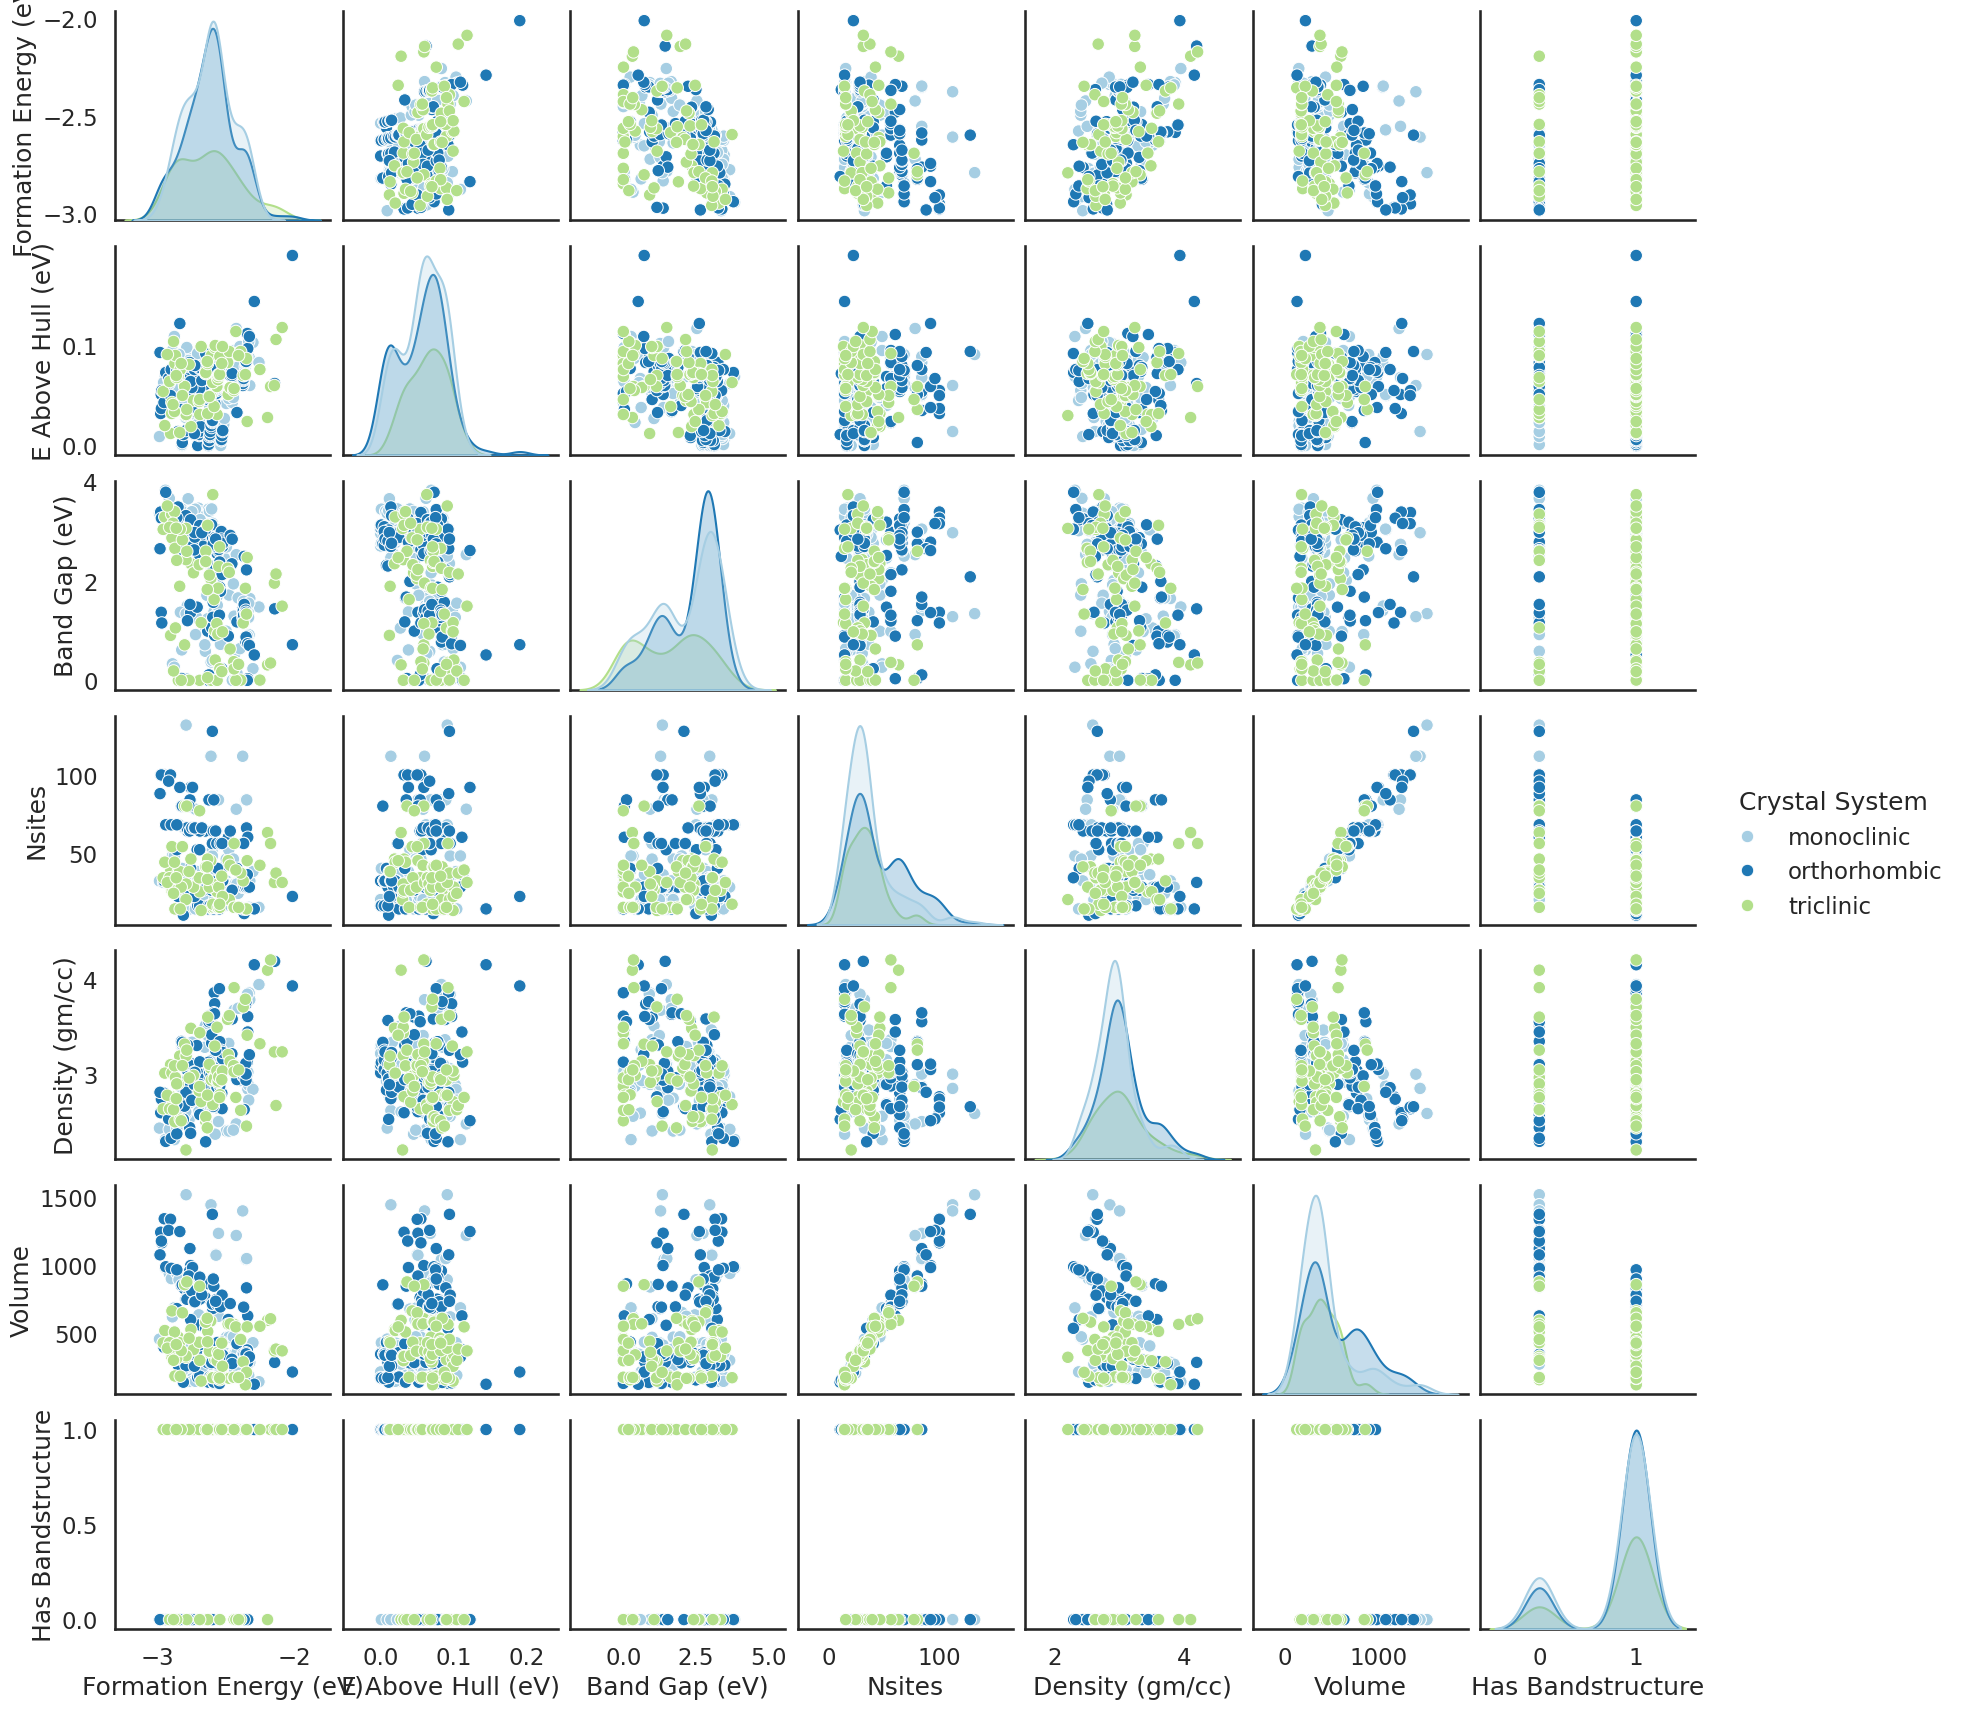

In [161]:
sns.set_context('talk')
sns.set_palette('Paired')
sns.set_style('white')

sns.pairplot(df, hue='Crystal System')

Create a bar plot showing the correlations between each column and y

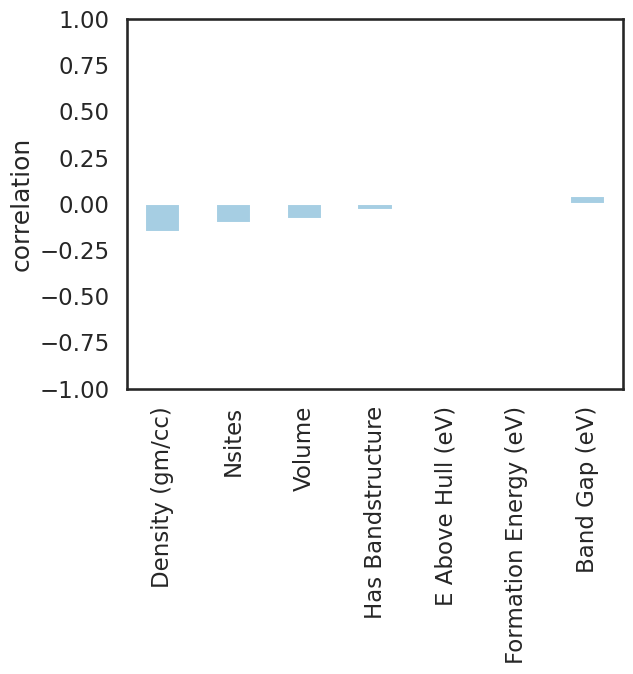

In [162]:
ax = correlations.plot(kind='bar')
ax.set(ylim=[-1, 1], ylabel='correlation');

In [163]:
from sklearn.preprocessing import MinMaxScaler

fields = correlations.map(abs).sort_values().iloc[-2:].index
print(fields)
X = df[fields]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=['%s_scaled' % fld for fld in fields])
print(X.columns)

Index(['Nsites', 'Density (gm/cc)'], dtype='object')
Index(['Nsites_scaled', 'Density (gm/cc)_scaled'], dtype='object')


In [164]:
print(accuracy_score(y_test, y_pred))

0.47058823529411764


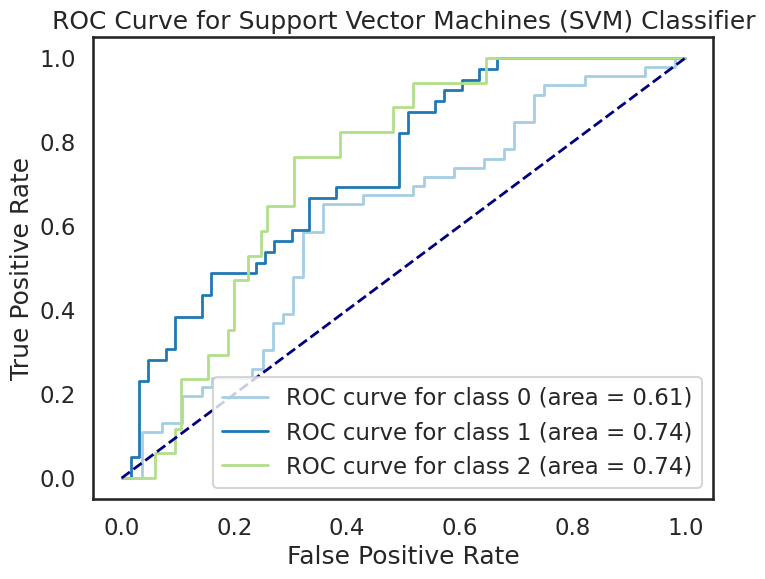

In [165]:
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Fit SVM classifier
svc = SVC(probability=True)
svc.fit(X_train, y_train)

# Predict probabilities for each class
svc_probs = svc.predict_proba(X_test)

# Binarize the target variable
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], svc_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y_test))):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for class {0} (area = {1:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Support Vector Machines (SVM) Classifier')
plt.legend(loc='lower right')
plt.show()


# MODEL SELECTION

Logistic Regression accuracy: 0.4412
Decision Tree accuracy: 0.5098
Random Forest accuracy: 0.6569
KNN accuracy: 0.5098
SVM accuracy: 0.5000


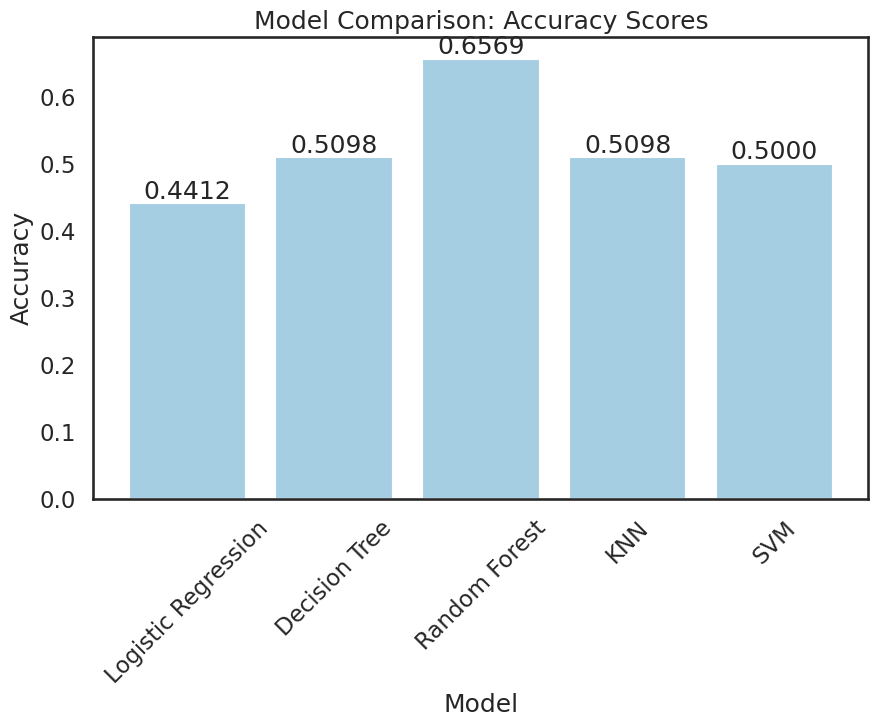

In [166]:
# Modeling
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    KNeighborsClassifier(n_neighbors=5, p=1),
    SVC(probability=True)
]

model_names = [
    "Logistic Regression",
    "Decision Tree",
    "Random Forest",
    "KNN",
    "SVM",
]

accuracies = []
for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f'{name} accuracy: {acc:.4f}')  # Specify precision explicitly

# Bar plot of accuracies
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Comparison: Accuracy Scores")
plt.xticks(rotation=45)
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{acc:.4f}', ha='center', va='bottom')  # Specify precision explicitly
plt.show()


#  HYPERPARAMETER TUNING

In [167]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier()
grid_search = GridSearchCV(rf_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_
best_rf_accuracy = best_rf_model.score(X_test, y_test)
best_rf_params = grid_search.best_params_

print(f'Best Random Forest model accuracy: {best_rf_accuracy}')
print(f'Best Random Forest hyperparameters: {best_rf_params}')

Best Random Forest model accuracy: 0.6274509803921569
Best Random Forest hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
